# Homework and bake-off: pragmatic color descriptions

In [ ]:
__author__ = "Christopher Potts"
__version__ = "CS224u, Stanford, Summer 2021"

## Contents

1. [Overview](#Overview)
1. [Set-up](#Set-up)
1. [All two-word examples as a dev corpus](#All-two-word-examples-as-a-dev-corpus)
1. [Dev dataset](#Dev-dataset)
1. [Random train–test split for development](#Random-train–test-split-for-development)
1. [Question 1: Improve the tokenizer [1 point]](#Question-1:-Improve-the-tokenizer-[1-point])
1. [Use the tokenizer](#Use-the-tokenizer)
1. [Question 2: Improve the color representations [1 point]](#Question-2:-Improve-the-color-representations-[1-point])
1. [Use the color representer](#Use-the-color-representer)
1. [Initial model](#Initial-model)
1. [Question 3: GloVe embeddings [1 point]](#Question-3:-GloVe-embeddings-[1-point])
1. [Try the GloVe representations](#Try-the-GloVe-representations)
1. [Question 4: Color context [3 points]](#Question-4:-Color-context-[3-points])
1. [Your original system [3 points]](#Your-original-system-[3-points])
1. [Bakeoff [1 point]](#Bakeoff-[1-point])
1. [Submission Instruction](#Submission-Instruction)

## Overview

This homework and associated bake-off are oriented toward building an effective system for generating color descriptions that are pragmatic in the sense that they would help a reader/listener figure out which color was being referred to in a shared context consisting of a target color (whose identity is known only to the describer/speaker) and a set of distractors.

The notebook [colors_overview.ipynb](colors_overview.ipynb) should be studied before work on this homework begins. That notebook provides backgroud on the task, the dataset, and the modeling code that you will be using and adapting.

The homework questions are more open-ended than previous ones have been. Rather than asking you to implement pre-defined functionality, they ask you to try to improve baseline components of the full system in ways that you find to be effective. As usual, this culminates in a prompt asking you to develop a novel system for entry into the bake-off. In this case, though, the work you do for the homework will likely be directly incorporated into that system (not required, but an efficient way to work at the very least).

## Set-up

See [colors_overview.ipynb](colors_overview.ipynb) for set-up in instructions and other background details.

In [164]:
from colors import ColorsCorpusReader
from nltk.translate.bleu_score import corpus_bleu
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torch_color_describer import ContextualColorDescriber
from torch_color_describer import create_example_dataset

import utils
from utils import START_SYMBOL, END_SYMBOL, UNK_SYMBOL

In [2]:
utils.fix_random_seeds()

In [3]:
COLORS_SRC_FILENAME = os.path.join(
    "data", "colors", "filteredCorpus.csv")

## All two-word examples as a dev corpus

So that you don't have to sit through excessively long training runs during development, I suggest working with the two-word-only subset of the corpus until you enter into the late stages of system testing.

In [4]:
dev_corpus = ColorsCorpusReader(
    COLORS_SRC_FILENAME,
    word_count=2,
    normalize_colors=True)

In [5]:
dev_examples = list(dev_corpus.read())

This subset has about one-third the examples of the full corpus:

In [6]:
len(dev_examples)

13890

We __should__ worry that it's not a fully representative sample. Most of the descriptions in the full corpus are shorter, and a large proportion are longer. So this dataset is mainly for debugging, development, and general hill-climbing. All findings should be validated on the full dataset at some point.

In [7]:
vars(dev_examples[0])

{'normalize_colors': True,
 'contents': 'Medium pink',
 'gameid': '1124-1',
 'roundNum': 3,
 'condition': 'close',
 'outcome': False,
 'clickStatus': 'distr2',
 'color_data': [{'type': 'click',
   'Status': 'distr2',
   'rep': [0.8083333333333333, 0.5, 0.59],
   'speaker': 3,
   'listener': 3},
  {'type': 'alt1',
   'Status': 'target',
   'rep': [0.8361111111111111, 0.5, 0.57],
   'speaker': 2,
   'listener': 2},
  {'type': 'alt2',
   'Status': 'distr1',
   'rep': [0.8388888888888889, 0.5, 0.86],
   'speaker': 1,
   'listener': 1}],
 'colors': [[0.8388888888888889, 0.5, 0.86],
  [0.8083333333333333, 0.5, 0.59],
  [0.8361111111111111, 0.5, 0.57]],
 'listener_context': [[0.8388888888888889, 0.5, 0.86],
  [0.8361111111111111, 0.5, 0.57],
  [0.8083333333333333, 0.5, 0.59]],
 'speaker_context': [[0.8388888888888889, 0.5, 0.86],
  [0.8361111111111111, 0.5, 0.57],
  [0.8083333333333333, 0.5, 0.59]]}

Medium pink


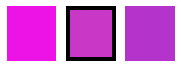

In [11]:
dev_examples[0].display(typ='speaker')

## Dev dataset

The first step is to extract the raw color and raw texts from the corpus:

In [7]:
dev_rawcols, dev_texts = zip(*[[ex.colors, ex.contents] for ex in dev_examples])

The raw color representations are suitable inputs to a model, but the texts are just strings, so they can't really be processed as-is. Question 1 asks you to do some tokenizing!

## Random train–test split for development

For the sake of development runs, we create a random train–test split:

In [8]:
dev_rawcols_train, dev_rawcols_test, dev_texts_train, dev_texts_test = \
    train_test_split(dev_rawcols, dev_texts)

## Question 1: Improve the tokenizer [1 point]

This is the first required question – the first required modification to the default pipeline.

The function `tokenize_example` simply splits its string on whitespace and adds the required start and end symbols:

In [57]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    from nltk.tokenize.casual import TweetTokenizer
    from nltk.tokenize.treebank import TreebankWordTokenizer
    from transformers import BertModel, BertTokenizer
    import vsm
    
    bert_weights_name = 'bert-base-uncased'
    bert_tokenizer = BertTokenizer.from_pretrained(bert_weights_name)
    bert_model = BertModel.from_pretrained(bert_weights_name)
    
    tokenizerTB = TreebankWordTokenizer()
    tokenizerTwtr = TweetTokenizer()

In [11]:
import os, utils
if 'IS_GRADESCOPE_ENV' not in os.environ:
    
    # Glove
    DATA_HOME = 'data'
    GLOVE_HOME = os.path.join(DATA_HOME, 'glove.6B')

    glove_lookup = utils.glove2dict(
        os.path.join(GLOVE_HOME, 'glove.6B.300d.txt'))

In [12]:
def vsm_phi(text, lookup, np_func=np.mean):
    """Represent `text` as a combination of the vector of its words.

    Parameters
    ----------
    text : str

    lookup : dict
        From words to vectors.

    np_func : function (default: np.sum)
        A numpy matrix operation that can be applied columnwise,
        like `np.mean`, `np.sum`, or `np.prod`. The requirement is that
        the function take `axis=0` as one of its arguments (to ensure
        columnwise combination) and that it return a vector of a
        fixed length, no matter what the size of the text is.

    Returns
    -------
    np.array, dimension `X.shape[1]`

    """
    allvecs = np.array([lookup[w] for w in text.split() if w in lookup])
    if len(allvecs) == 0:
        dim = len(next(iter(lookup.values())))
        feats = np.zeros(dim)
    else:
        feats = np_func(allvecs, axis=0)
    return feats

def glove_phi(text, np_func=np.mean):
    return vsm_phi(text, glove_lookup, np_func=np_func)

In [13]:
# glove_phi(dev_texts_train[376])

In [58]:
def tokenize_example_baseline(s):
    return [START_SYMBOL] + s.split() + [END_SYMBOL]

In [15]:
def tokenize_example(s):

    # Improve me!
    
    # Ideas:  BERT tokens, Twitter tokenizaiton, TreebankWordTokenizer
    # GloVe?
    # Read paper
    ''' Twitter tokenization'''
    #twttr_tokens = tokenizerTwtr.tokenize(s)    
    ''' TreebankWordTokenizer '''
    #tbw_tokens = tokenizerTB.tokenize(s)    
    
    ''' BERT'''
    bert_token = bert_tokenizer.tokenize(s)
    
#     print('Whitespace: ',[START_SYMBOL] + s.split() + [END_SYMBOL])
#     print('Twitter: ',[START_SYMBOL] + twttr_tokens + [END_SYMBOL])
#     print('TreebankWordTokenizer: ',[START_SYMBOL] + tbw_tokens + [END_SYMBOL])
#     print('BERT: ',[START_SYMBOL] + bert_token + [END_SYMBOL])
    
    return [START_SYMBOL] + bert_token + [END_SYMBOL]

In [61]:
def tokenize_example_twr(s):
    twttr_tokens = tokenizerTwtr.tokenize(s)       
    return [START_SYMBOL] + twttr_tokens + [END_SYMBOL]

In [16]:
tokenize_example(dev_texts_train[376])

['<s>', 'aqua', ',', 'tea', '##l', '</s>']

In [17]:
tokenize_example_baseline(dev_texts_train[376])

['<s>', 'aqua,', 'teal', '</s>']

In [62]:
tokenize_example_twr(dev_texts_train[376])

['<s>', 'aqua', ',', 'teal', '</s>']

In [80]:
text = dev_texts_train[376]
vsm.hf_encode(text, bert_tokenizer, add_special_tokens=True)

tensor([[  101, 28319,  1010,  5572,  2140,   102]])

__Your task__: Modify `tokenize_example` so that it does something more sophisticated with the input text. 

__Notes__:

* There are useful ideas for this in [Monroe et al. 2017](https://transacl.org/ojs/index.php/tacl/article/view/1142)
* There is no requirement that you do word-level tokenization. Sub-word and multi-word are options.
* This question can interact with the size of your vocabulary (see just below), and in turn with decisions about how to use `UNK_SYMBOL`.

__Important__: don't forget to add the start and end symbols, else the resulting models will definitely be terrible! The following test will check that your tokenizer has this property:

In [13]:
def test_tokenize_example(func):
    s = "A test string"
    result = func(s)
    assert all(isinstance(tok, str) for tok in result), \
        "The tokenizer must return a list of strings."
    assert result[0] == START_SYMBOL, \
        "The tokenizer must add START_SYMBOL as the first token."
    assert result[-1] == END_SYMBOL, \
        "The tokenizer must add END_SYMBOL as the final token."

In [14]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    test_tokenize_example(tokenize_example)

## Use the tokenizer

Once the tokenizer is working, run the following cell to tokenize your inputs:

In [71]:
dev_seqs_train = [tokenize_example(s) for s in dev_texts_train]

dev_seqs_test = [tokenize_example(s) for s in dev_texts_test]

In [18]:
dev_seqs_train_base = [tokenize_example_baseline(s) for s in dev_texts_train]
dev_seqs_test_base = [tokenize_example_baseline(s) for s in dev_texts_test]

We use only the train set to derive a vocabulary for the model:

In [72]:
dev_vocab = sorted({w for toks in dev_seqs_train for w in toks})

dev_vocab += [UNK_SYMBOL]

In [19]:
dev_vocab_base = sorted({w for toks in dev_seqs_train_base for w in toks})

dev_vocab_base += [UNK_SYMBOL]

It's important that the `UNK_SYMBOL` is included somewhere in this list. In test examples, words not seen in training will be mapped to `UNK_SYMBOL`. 

Conceptual note: If you model's vocab is the same as your train vocab, then `UNK_SYMBOL` will never be encountered during training, so it will be a random vector at test time.

In [17]:
len(dev_vocab)

963

In [20]:
len(dev_vocab_base)

1439

## Question 2: Improve the color representations [1 point]

This is the second required pipeline improvement for the assignment. 

The following functions do nothing at all to the raw input colors we get from the corpus. 

In [21]:
from itertools import product

def HSLtoHSV(hsl):
    ''' reference: en.wikipedia.org/wiki/HSL_and_HSV#HSL_to_HSV
    '''
    h, s, l = hsl    
    v = l + s*min(l, 1-l)    
    s = 0 if v ==0 else 2*(1-(l/v))    
    return [h, s, v]

In [22]:
def represent_color_context(colors):
    # Improve me!
    return [represent_color(color) for color in colors]


# def represent_color(color):
#     ''' color:  HSL format and nomalized '''        
#     h, s, v = HSLtoHSV(color)
#     real_vector = []
#     img_vector = []
#     for j, k, l in product((0, 1, 2), repeat=3):
#         fourier = np.exp(-1*2j * np.pi *(j*h + k*s + l*v))
#         real_vector.append(fourier.real)
#         img_vector.append(fourier.imag)
#     return real_vector + img_vector
#     #return color
    
def represent_color(color):
    ''' color:  HSL format and nomalized '''        
    h, s, v = HSLtoHSV(color)
    vector = []
    img_vector = []
    for j, k, l in product((0, 1, 2), repeat=3):
        fourier = np.exp(-1*2j * np.pi *(j*h + k*s + l*v))
        vector.append(fourier.real)
        vector.append(fourier.imag)
    return vector    

In [20]:
color_ex1 = dev_rawcols_train[0][0]
color_verification = [0.19444444444444445, 0.5, 0.11]

In [70]:
color_ex1

[0.19444444444444445, 0.5, 0.11]

In [81]:
HSLtoHSV(color_verification)

[0.19444444444444445, 0.6666666666666667, 0.165]

In [88]:
HSLtoHSV([70/360, 50/100, 11/100]) # verifying discussion with Michael Kamfonas, Rafiq Mohammadi, and Akash Singh

[0.19444444444444445, 0.6666666666666667, 0.165]

In [108]:
fourier_color = represent_color_context(dev_rawcols_train[0])

In [110]:
print(len(fourier_color), len(fourier_color[0]))

3 54


__Your task__: Modify `represent_color_context` and/or `represent_color` to represent colors in a new way.
    
__Notes__:

* You are not required to keep `represent_color`. This might be unnatural if you want to perform an operation on each color trio all at once.
* For that matter, if you want to process all of the color contexts in the entire data set all at once, that is fine too, as long as you can also perform the operation at test time with an unknown number of examples being tested.

* The Fourier-transform method of [Monroe et al. 2016](https://www.aclweb.org/anthology/D16-1243/) and [Monroe et al. 2017](https://transacl.org/ojs/index.php/tacl/article/view/1142) is a proven choice for our task. __It is not required that you implement this.__ However, if you decide to, you might find that the overly terse presentation in the paper is an obstacle. They key thing to see is that the notation $\hat{f}_{jkl}$ is meant to specify a full coordinate system. Thus, you might do something like

  ```
from itertools import product
for j, k, l in product((0, 1, 2), repeat=3):    
    f_jkl = ...
```

  and collect these `f_jkl` values in a list of 27 values. Additionally, in Python, [`2j` produces a value with `real` and `imag` attributes](https://docs.python.org/3.7/library/cmath.html). Each element `f_jkl` should have these components. If you concatenate the `real` and `imag` parts of all the `f_jkl`, you will have a 54-dimensional representation, as in the paper. Remember to start with an HSV representation, and with $h$ in $[0, 360]$, $s$ in $[0, 200]$, and $v$ in $[0, 200]$ (or else do the scaling differently). Note that the values in our corpus are in HLS format, [which are easily converted to HSV](https://en.wikipedia.org/wiki/HSL_and_HSV#HSL_to_HSV).
  
* It's natural to ask why this Fourier transform is useful in the current context. This is a challenging question, and I don't have a complete answer, but here is an intuitive observation: if you consider the raw color representations to be embeddings, then you can see very quickly that our standard geometric notions are totally out of line with our intuitions about the colors themselves. For example, here is a plot where we simply vary the hue dimension while keeping the other dimensions constant:

  <img src="fig/colors-hue-hls.png" alt="A series of very different colors with cosine distances from orange ranging from 0 to 0.19" />

  I've printed the cosine distances from the leftmost color above each patch. They all look pretty similar. Now, you might say, well at least the distances are sort of proportional to how different the colors are from the first. However, that argument seems to crumble when we do the same experiment but now varying the saturation dimension:

  <img src="fig/colors-saturation-hls.png" alt="A series of very similar purple-ish colors with cosine distances from gray-purple ranging from 0 to 0.19" />

  These colors are all quite simular intuitively. Notice, though, that the cosine distances are identical to my first plot. Of course! Cosine distances doesn't care about the nature of these dimensions! The underlying color space is a cylinder, not a regular Euclidean 3d space!
  
  The Fourier transformation that we apply is remapping the colors into approximately the cylindrical space that we want. It is at least capturing some the circular/radial relationships that are inherent in the space. Thus, here are plots corresponding to the above, but now where the colors have been transformed for the cosine comparisons. 
  
  First, the hue variation:
  
  <img src="fig/colors-hue-fourier.png" alt="A series of very different colors with cosine distances from orange that are generally large (near 1.0)" />

  And then saturation:
  
  <img src="fig/colors-saturation-fourier.png" alt="A series of very similar purple-ish colors with cosine distances from gray purple that seem aligned with visual color similarity" />
  
  These distances seem much better aligned with intuitions to me, and I think that's quite general. Thus, even if our networks can in principle learn this remapping, it's very helpful to at least start them closer to where we want them to be.
  
  If you want to go one layer deeper, then the [Zhang and Lu 2002](https://www.sciencedirect.com/science/article/pii/S092359650200084X) paper that Monroe et al. 2016 cite is pretty intuitive. It's for the 2d case, but that actually makes the ideas somewhere more accessible, since they can easily plot the original and remapped feature spaces.

In [23]:
a = represent_color((0.9, 0.5, 0.1))
b = represent_color((0.9, 0.5, 0.3))
c = represent_color((0.9, 0.5, 0.5))
d = represent_color((0.9, 0.5, 0.7))
e = represent_color((0.9, 0.5, 0.9))

print([vsm.cosine(a, a), vsm.cosine(a, b), vsm.cosine(a, c), vsm.cosine(a, d), vsm.cosine(a, e)])

[0, 1.0393446629166314, 0.8333333333333336, 1.007066697868587, 1.0109782933538725]


In [22]:
vsm.cosine(a, c)

0.8333333333333336

In [23]:
vsm.cosine(a, d)

1.007066697868587

In [24]:
vsm.cosine(a, e)

1.0109782933538725

The following test seeks to ensure only that the output of your `represent_color_context` will be compatible with the models we are creating:

In [25]:
def test_represent_color_context(func):
    """`func` should be `represent_color_context`"""
    example = [
        [0.786, 0.58, 0.87],
        [0.689, 0.44, 0.92],
        [0.628, 0.32, 0.81]]
    result = func(example)
    assert len(result) == len(example), \
        ("Color context representations need to represent each color "
         "separately. (We assume the final color is the target.)")
    for i, color in enumerate(result):
        assert all(isinstance(x, float) for x in color), \
            ("All color representations should be lists of floats. "
             "Color {} is {}".format(i, color))

In [26]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    test_represent_color_context(represent_color_context)

## Use the color representer

The following cell just runs your `represent_color_context` on the train and test sets:

In [24]:
dev_cols_train = [represent_color_context(colors) for colors in dev_rawcols_train]

dev_cols_test = [represent_color_context(colors) for colors in dev_rawcols_test]

Exploring results:

In [29]:
print(len(dev_cols_train), len(dev_cols_train[0]),len(dev_cols_train[0][0] ))

10417 3 54


In [35]:
print(len(dev_seqs_train_base), len(dev_seqs_train_base[0]))

10417 4


In [36]:
dev_seqs_train_base[:5]

[['<s>', 'lime', 'green', '</s>'],
 ['<s>', 'lime', 'green', '</s>'],
 ['<s>', 'drab', 'purple', '</s>'],
 ['<s>', 'YELLLOW', 'green', '</s>'],
 ['<s>', 'pretty', 'in', '</s>']]

In [39]:
dev_vocab_base[:5]

['###', "'light", '(Nice!)', '(blue)', '(bright']

At this point, our preprocessing steps are complete, and we can fit a first model.

## Initial model

The first model is configured right now to be a small model run for just a few iterations. It should be enough to get traction, but it's unlikely to be a great model. You are free to modify this configuration if you wish; it is here just for demonstration and testing:

In [64]:
dev_mod = ContextualColorDescriber(
    dev_vocab,
    early_stopping=True)

In [65]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    %time _ = dev_mod.fit(dev_cols_train, dev_seqs_train)
else:
    dev_mod.fit(dev_cols_train, dev_seqs_train)

Stopping after epoch 98. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 38.96868586540222

CPU times: user 42min 48s, sys: 1min 33s, total: 44min 21s
Wall time: 11min 55s


The canonical bake-off evaluation function is `evaluate`. Our primary metric is `listener_accuracy`; the BLEU score is included as a check to ensure that your system is speaking English!

In [66]:
evaluation = dev_mod.evaluate(dev_cols_test, dev_seqs_test)

In [67]:
evaluation.keys()

dict_keys(['listener_accuracy', 'corpus_bleu', 'target_index', 'predicted_index', 'predicted_utterance'])

In [68]:
evaluation['listener_accuracy']

0.7921105672329398

In [69]:
dev_mod.listener_accuracy(dev_cols_test, dev_seqs_test)

0.7921105672329398

In [70]:
evaluation['corpus_bleu']

0.6319393719620887

In [71]:
bleu, predicted_utterances = dev_mod.corpus_bleu(dev_cols_test, dev_seqs_test)

bleu

0.6319393719620887

In [122]:
evaluation['target_index'][: 5]

[2, 2, 2, 2, 2]

In [123]:
evaluation['predicted_index'][: 5]

[2, 0, 2, 0, 2]

In [124]:
evaluation['predicted_utterance'][: 5]

[['<s>', 'bright', 'purple', '</s>'],
 ['<s>', 'yellow', 'green', '</s>'],
 ['<s>', 'dull', 'purple', '</s>'],
 ['<s>', 'hot', 'pink', '</s>'],
 ['<s>', 'bright', 'green', '</s>']]

We can also see the model's predicted sequences given color context inputs:

In [125]:
dev_mod.predict(dev_cols_test[: 1])

[['<s>', 'bright', 'purple', '</s>']]

In [126]:
dev_seqs_test[: 1]

[['<s>', 'right', 'side', '#', '#', '#', 'purple', 'pink', '##ish', '</s>']]

## Question 3: GloVe embeddings [1 point]

The above model uses a random initial embedding, as configured by the decoder used by `ContextualColorDescriber`. This homework question asks you to consider using GloVe inputs. 

__Your task__: Complete `create_glove_embedding` so that it creates a GloVe embedding based on your model vocabulary. This isn't mean to be analytically challenging, but rather just to create a basis for you to try out other kinds of rich initialization.

In [51]:
GLOVE_HOME = os.path.join('data', 'glove.6B')

In [69]:
def create_glove_embedding(vocab, glove_base_filename='glove.6B.50d.txt'):
    pass
    # Use `utils.glove2dict` to read in the GloVe file:

    ##### YOUR CODE HERE
    glove_lookup = utils.glove2dict(
        os.path.join(GLOVE_HOME, glove_base_filename))

    # Use `utils.create_pretrained_embedding` to create the embedding.
    # This function will, by default, ensure that START_TOKEN,
    # END_TOKEN, and UNK_TOKEN are included in the embedding.

    ##### YOUR CODE HERE
    embedding, vocab2 = utils.create_pretrained_embedding(glove_lookup, vocab)

    # Be sure to return the embedding you create as well as the
    # vocabulary returned by `utils.create_pretrained_embedding`,
    # which is likely to have been modified from the input `vocab`.

    ##### YOUR CODE HERE
    return embedding, vocab2 


In [53]:
def test_create_glove_embedding(func):
    vocab = ['NLU', 'is', 'the', 'future', '.', '$UNK', '<s>', '</s>']
    glove_embedding, glove_vocab = func(vocab, 'glove.6B.50d.txt')
    assert isinstance(glove_embedding, np.ndarray), \
        "Expected embedding type {}; got {}".format(
        glove_embedding.__class__.__name__, glove_embedding.__class__.__name__)
    assert glove_embedding.shape == (8, 50), \
        "Expected embedding shape (8, 50); got {}".format(glove_embedding.shape)
    assert glove_vocab == vocab, \
        "Expected vocab {}; got {}".format(vocab, glove_vocab)

In [54]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    test_create_glove_embedding(create_glove_embedding)

## Try the GloVe representations

The extent to which GloVe is useful will depend heavily on how aligned your tokenization scheme is with the GloVe vocabulary. For example, if you did character-level tokenization, then the GloVe embedding space is not well-aligned with your tokenizer and using GloVe should have little no positive effect.

Let's see if GloVe helped for our development data:

In [73]:
dev_glove_embedding, dev_glove_vocab = create_glove_embedding(dev_vocab)

In [74]:
print(dev_glove_embedding.shape)
dev_glove_embedding[0]

(963, 50)


array([-0.58402 ,  0.39031 ,  0.65282 , -0.3403  ,  0.19493 , -0.83489 ,
        0.11929 , -0.57291 , -0.56844 ,  0.72989 , -0.56975 ,  0.53436 ,
       -0.38034 ,  0.22471 ,  0.98031 , -0.2966  ,  0.126   ,  0.55222 ,
       -0.62737 , -0.082242, -0.085359,  0.31515 ,  0.96077 ,  0.31986 ,
        0.87878 , -1.5189  , -1.7831  ,  0.35639 ,  0.9674  , -1.5497  ,
        2.335   ,  0.8494  , -1.2371  ,  1.0623  , -1.4267  , -0.49056 ,
        0.85465 , -1.2878  ,  0.60204 , -0.35963 ,  0.28586 , -0.052162,
       -0.50818 , -0.63459 ,  0.33889 ,  0.28416 , -0.2034  , -1.2338  ,
        0.46715 ,  0.78858 ])

In [76]:
len(dev_glove_vocab)

963

In [81]:
print(len(dev_vocab))
dev_vocab[100]

963


'##ih'

In [141]:
print(len(dev_glove_vocab))
dev_glove_vocab[100]


963


'##ih'

In [82]:
dev_mod_glove = ContextualColorDescriber(
    dev_glove_vocab,
    embedding=dev_glove_embedding,
    early_stopping=True)

In [83]:
%time _ = dev_mod_glove.fit(dev_cols_train, dev_seqs_train)

/home/vicaran93/repos/AI-certificate-stanford/CS224/cs224u/torch_color_describer.py:680: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 1 of 1000; error is 67.78663444519043/home/vicaran93/repos/AI-certificate-stanford/CS224/cs224u/torch_color_describer.py:680: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Stopping after epoch 145. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 32.31510829925537

CPU times: user 1h 1min 58s, sys: 1min 26s, total: 1h 3min 24s
Wall time: 17min 3s


In [84]:
dev_mod_glove.listener_accuracy(dev_cols_test, dev_seqs_test)

0.8036279873308378

You probably saw a small boost, assuming your tokeization scheme leads to good overlap with the GloVe vocabulary. The input representations are larger than in our previous model (at least as I configured things), so we would need to do more runs with higher `max_iter` values to see whether this is worthwhile overall.

## Question 4: Color context [3 points]

The final required homework question is the most challenging, but it should set you up to think in much more flexible ways about the underlying model we're using.

The question asks you to modify various model components in `torch_color_describer.py`. The section called [Modifying the core model](colors_overview.ipynb#Modifying-the-core-model) from the core unit notebook provides a number of examples illustrating the basic techniques, so you might review that material if you get stuck here.

__Your task__: Building on ideas from [Monroe et al. 2017](https://transacl.org/ojs/index.php/tacl/article/view/1142), you will redesign the model so that the target color (the final one in the context) is appended to each input token that gets processed by the decoder. The question asks you to subclass the `Decoder` and `EncoderDecoder` from `torch_color_describer.py` so that you can build models that do this.

__Step 1__: Modify the `Decoder` so that the input vector to the model at each timestep is not just a token representation `x` but the concatenation of `x` with the representation of the target color.

__Notes__:

* You might notice at this point that the original `Decoder.forward` method has an optional keyword argument `target_colors` that is passed to `Decoder.get_embeddings`. Because this is already in place, all you have to do is modify the `get_embeddings` method to use this argument.

* The change affects the configuration of `self.rnn`, so you need to subclass the `__init__` method as well, so that its `input_size` argument accomodates the embedding as well as the color representations.

* You can do the relevant operations efficiently in pure PyTorch using `repeat_interleave` and `cat`, but the important thing is to get a working implementation – you can always optimize the code later if the ideas prove useful to you. 

Here's skeleton code for you to flesh out:

In [149]:
from torch_color_describer import Decoder
import torch
import torch.nn as nn


class ColorContextDecoder(Decoder):
    def __init__(self, color_dim, *args, **kwargs):
        self.color_dim = color_dim
        super().__init__(*args, **kwargs)

        # Fix the `self.rnn` attribute:
        ##### YOUR CODE HERE
        self.rnn = nn.GRU(
            input_size=self.embed_dim + color_dim,            
            hidden_size=self.hidden_dim,
            batch_first=True)


    def get_embeddings(self, word_seqs, target_colors=None):
        """
        You can assume that `target_colors` is a tensor of shape
        (m, n), where m is the length of the batch (same as
        `word_seqs.shape[0]`) and n is the dimensionality of the
        color representations the model is using. The goal is
        to attached each color vector i to each of the tokens in
        the ith sequence of (the embedded version of) `word_seqs`.

        """
        ##### YOUR CODE HERE
        # concat embeddings with target colors:
        if target_colors != None:
            pass
            ''' Testing:
            print("self.embedding(word_seqs) size:\n", self.embedding(word_seqs).size())
            print("self.embedding(word_seqs)\n", self.embedding(word_seqs))
            print("rows in embedding:\n", self.embedding(word_seqs).shape[1])
            
            print("target_colors size:\n", target_colors.size())
            print("target_colors:\n", target_colors) 
            '''
            
            n_seq = len(word_seqs)
            n_embeddings_per_seq = word_seqs.shape[1]
            target_cols = target_colors.shape[1]      
            #print(word_seqs)
            #print("word_seqs Shape: ",word_seqs.shape )
            #print(target_colors[:2])
            #print("target_colors Shape: ",target_colors.shape )
            embedding = self.embedding(word_seqs)
            #print(embedding[:3])
            #print("embedding Shape: ",embedding.shape )
            
            #print("reshape: ", n_seq, n_embeddings_per_seq, target_cols )
            
            # Repeat and Reshape
            x = torch.repeat_interleave(target_colors, n_embeddings_per_seq, dim=0)
            
            #print("repeated target_colors Shape: ",x.shape )
            
        
            x_reshaped = torch.reshape(x, (n_seq, n_embeddings_per_seq, target_cols))
        
            #print("embedding size vs target 3 size:", self.embedding(word_seqs).size(), x_reshaped.size() )
            #print(torch.cat((self.embedding(word_seqs), x_reshaped), 2))
            return torch.cat((self.embedding(word_seqs), x_reshaped), 2)
        
        else:                     
            return self.embedding(word_seqs)



Step 1 is the most demanding of the steps in terms of tensor wrangling. It's important to have a clear idea of what you are trying to achieve and to unit test `get_embeddings` so that you can check that it has realized your vision. The following test should help with that:

In [55]:
def test_get_embeddings(decoder_class):
    """
    It's assumed that the input to this will be `ColorContextDecoder`.
    You pass in the class, and the function initalizes it with the test
    parameters.
    """
    dec = decoder_class(
        color_dim=3,   # For these, we mainly want *different*
        vocab_size=10, # dimensions so that we reliably get
        embed_dim=4,   # dimensionality errors if something
        hidden_dim=5)  # isn't working.

    # This step just changes the embedding to one with values
    # that are easy to inspect and definitely will not change
    # between runs:
    dec.embedding = nn.Embedding.from_pretrained(
        torch.FloatTensor([
            [10, 11, 12, 13],
            [14, 15, 16, 17],
            [18, 19, 20, 21]]))

    # These are the incoming sequences -- lists of indices
    # into the rows of `dec.embedding`:
    word_seqs = torch.tensor([
        [0,1,2],
        [2,0,1]])

    # Target colors as small floats that will be easy to track:
    target_colors = torch.tensor([
        [0.1, 0.2, 0.3],
        [0.7, 0.8, 0.9]])

    # The desired return value: one list of tensors for each of
    # the two sequences in `word_seqs`. Each index is replaced
    # with its vector from `dec.embedding` and has the
    # corrresponding color from `target_colors` appended to it.
    expected = torch.tensor([
        [[10., 11., 12., 13.,  0.1,  0.2,  0.3],
         [14., 15., 16., 17.,  0.1,  0.2,  0.3],
         [18., 19., 20., 21.,  0.1,  0.2,  0.3]],

        [[18., 19., 20., 21.,  0.7,  0.8,  0.9],
         [10., 11., 12., 13.,  0.7,  0.8,  0.9],
         [14., 15., 16., 17.,  0.7,  0.8,  0.9]]])

    result = dec.get_embeddings(word_seqs, target_colors=target_colors)

    assert expected.shape == result.shape, \
        "Expected shape {}; got shape {}".format(expected.shape, result.shape)

    assert torch.all(expected.eq(result)), \
        ("Your result has the desired shape but the values aren't correct. "
         "Here's what your function creates; compare it with `expected` "
         "from the test:\n{}".format(result))

In [56]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    test_get_embeddings(ColorContextDecoder)

__Step 2__: Modify the `EncoderDecoder`. For this, you just need to make a small change to the `forward` method: extract the target colors from `color_seqs` and feed them to the decoder.

In [158]:
from torch_color_describer import EncoderDecoder

class ColorizedEncoderDecoder(EncoderDecoder):

    def forward(self,
            color_seqs,
            word_seqs,
            seq_lengths=None,
            hidden=None,
            targets=None):
        if hidden is None:
            hidden = self.encoder(color_seqs)

        # Extract the target colors from `color_seqs` and
        # feed them to the decoder, which already has a
        # `target_colors` keyword.

        ##### YOUR CODE HERE
        # Extract the target colors from color_seqs:                
        
        # list of tensors
        #targets = [seq[-1] for seq in color_seqs]    
        
        # slicing existing tensor
        x,y,z = color_seqs.shape        
        targets = color_seqs[:,y-1:y,:]
        #print('targets2new: \n',targets[:3])
        #targets = color_seqs[:,2:3,:]
        #print('targets2old: \n',targets[:3])
        
        targets = torch.reshape(targets, (targets.shape[0], targets.shape[-1]))
        #print('targets3: \n',targets[:3])
        
        
        # this will call the forward decoder method which will call the get_embeddings from ColorContextDecoder
        output, hidden = self.decoder(word_seqs, seq_lengths=seq_lengths, hidden=hidden, target_colors=targets)
        

        # Your decoder will return `output, hidden` pairs; the
        # following will handle the two return situations that
        # the code needs to consider -- training and prediction.
        if self.training:
            return output
        else:
            return output, hidden

__Step 3__: Finally, as in the examples in [Modifying the core model](colors_overview.ipynb#Modifying-the-core-model), you need to modify the `build_graph` method of `ContextualColorDescriber` so that it uses your new `ColorContextDecoder` and `ColorizedEncoderDecoder`. Here's starter code:

In [151]:
from torch_color_describer import Encoder

class ColorizedInputDescriber(ContextualColorDescriber):

    def build_graph(self):

        # We didn't modify the encoder, so this is
        # just copied over from the original:
        encoder = Encoder(
            color_dim=self.color_dim,
            hidden_dim=self.hidden_dim)

        # Use your `ColorContextDecoder`, making sure
        # to pass in all the keyword arguments coming
        # from `ColorizedInputDescriber`:

        ##### YOUR CODE HERE
        decoder = ColorContextDecoder(self.color_dim,\
                                        vocab_size=self.vocab_size,
                                        embed_dim=self.embed_dim,
                                        embedding=self.embedding,
                                        hidden_dim=self.hidden_dim)


        # Return a `ColorizedEncoderDecoder` that uses
        # your encoder and decoder:

        ##### YOUR CODE HERE
        
        return ColorizedEncoderDecoder(encoder, decoder)


That's it! Since these modifications are pretty intricate, you might want to use [a toy dataset](colors_overview.ipynb#Toy-problems-for-development-work) to debug it:

In [147]:
def test_full_system(describer_class):
    toy_color_seqs, toy_word_seqs, toy_vocab = create_example_dataset(
        group_size=50, vec_dim=2)

    toy_color_seqs_train, toy_color_seqs_test, toy_word_seqs_train, toy_word_seqs_test = \
        train_test_split(toy_color_seqs, toy_word_seqs)

    toy_mod = describer_class(toy_vocab)

    _ = toy_mod.fit(toy_color_seqs_train, toy_word_seqs_train)

    acc = toy_mod.listener_accuracy(toy_color_seqs_test, toy_word_seqs_test)

    return acc

In [159]:
test_full_system(ColorizedInputDescriber)

Finished epoch 1000 of 1000; error is 0.11665120720863342

1.0

If that worked, then you can now try this model on SCC problems!

## Your original system [3 points]

There are many options for your original system, which consists of the full pipeline – all preprocessing and modeling steps. You are free to use any model you like, as long as you subclass `ContextualColorDescriber` in a way that allows its `evaluate` method to behave in the expected way.

So that we can evaluate models in a uniform way for the bake-off, we ask that you modify the function `evaluate_original_system` below so that it accepts a trained instance of your model and does any preprocessing steps required by your model.

If we seek to reproduce your results, we will rerun this entire notebook. Thus, it is fine if your `evaluate_original_system` makes use of functions you wrote or modified above this cell.

In [111]:
def evaluate_original_system(trained_model, color_seqs_test, texts_test, tokenization = "default", fourier = True):
    """
    Feel free to modify this code to accommodate the needs of
    your system. Just keep in mind that it will get raw corpus
    examples as inputs for the bake-off.

    """
    # `word_seqs_test` is a list of strings, so tokenize each of
    # its elements:
    # TODO: get tokenization func as param if endup creating many
    if tokenization == 'default':
        tok_seqs = [tokenize_example(s) for s in texts_test]
    elif tokenization == 'whitespace':
        tok_seqs = [tokenize_example_baseline(s) for s in texts_test]        
    elif tokenization == 'twitter':
        tok_seqs = [tokenize_example_twr(s) for s in texts_test] 
    elif tokenization == 'tokenize_bert_ex4':
        tok_seqs = [tokenize_bert_ex4(s) for s in texts_test] 
    else:
        raise "Unexpected tokenization method"
        

    if fourier:
        col_seqs = [represent_color_context(colors)
                    for colors in color_seqs_test]
    else:
        col_seqs = color_seqs_test


    # Optionally include other preprocessing steps here. Note:
    # DO NOT RETRAIN YOUR MODEL AS PART OF THIS EVALUATION!
    # It's a tempting step, but it's a mistake and will get
    # you disqualified!

    # The following core score calculations are required:
    evaluation = trained_model.evaluate(col_seqs, tok_seqs)

    return evaluation

If `evaluate_original_system` works on test sets you create from the corpus distribution, then it will work for the bake-off, so consider checking that. For example, this would check that `dev_mod` above passes muster:

In [72]:
my_evaluation = evaluate_original_system(dev_mod, dev_rawcols_test, dev_texts_test)

In [73]:
my_evaluation['listener_accuracy']

0.7921105672329398

In [74]:
my_evaluation['corpus_bleu']

0.6319393719620887

----
---

In [ ]:
# dev_rawcols, dev_texts = zip(*[[ex.colors, ex.contents] for ex in dev_examples])
# dev_rawcols_train, dev_rawcols_test, dev_texts_train, dev_texts_test = \
#     train_test_split(dev_rawcols, dev_texts)

# dev_seqs_train = [tokenize_example(s) for s in dev_texts_train]
# dev_seqs_test = [tokenize_example(s) for s in dev_texts_test]	

# # Whitespace
# dev_seqs_train_base = [tokenize_example_baseline(s) for s in dev_texts_train]
# dev_seqs_test_base = [tokenize_example_baseline(s) for s in dev_texts_test]
# # Twitter
# dev_seqs_train_twr= [tokenize_example_baseline(s) for s in dev_texts_train]
# dev_seqs_test_twr = [tokenize_example_baseline(s) for s in dev_texts_test]


# dev_vocab = sorted({w for toks in dev_seqs_train for w in toks})
# dev_vocab += [UNK_SYMBOL]


# dev_vocab_base = sorted({w for toks in dev_seqs_train_base for w in toks})
# dev_vocab_base += [UNK_SYMBOL]

# dev_cols_train = [represent_color_context(colors) for colors in dev_rawcols_train]
# dev_cols_test = [represent_color_context(colors) for colors in dev_rawcols_test]
`

In [40]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    import pickle


**Experiment 0**: Baseline with simple dev_mod and colors not represented by fourier transform

In [41]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    ''' 
    Tokenization: Whitespace
    Colors: no change
    Embedding: default - random initial embedding, as configured by the decoder used by 
                    ContextualColorDescriber
    Model: default
    '''
    dev_mod_base = ContextualColorDescriber(
        dev_vocab_base,
        early_stopping=True)
    
    # dev_rawcols_train
    dev_mod_base.fit(dev_rawcols_train, dev_seqs_train_base)
    
#     pickle.dump(dev_mod_base, open('models_backup/dev_mod_base.sav', 'wb'))
    

Stopping after epoch 12. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 51.017526149749756

In [46]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    # old evaluate function
    ex0_evaluation = evaluate_original_system(dev_mod_base, dev_rawcols_test, dev_texts_test, baseline=True, fourier = False)    
    print(ex0_evaluation['listener_accuracy'])
    print(ex0_evaluation['corpus_bleu'])

0.39965447739706306
0.05711200691045207


In [ ]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    # With new evaluate function
    ex0_evaluation = evaluate_original_system(dev_mod_base, dev_rawcols_test, dev_texts_test, tokenization="whitespace", fourier = False)    
    print(ex0_evaluation['listener_accuracy'])
    print(ex0_evaluation['corpus_bleu'])

**Experiment 0.1**: Baseline with dev_mod based on whitspace tokenization and colors represented by fourier transform

In [47]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    ''' 
    Tokenization: Whitespace
    Colors: Fourier
    Embedding: default - random initial embedding, as configured by the decoder used by 
                    ContextualColorDescriber
    Model: default
    '''
    dev_mod_base = ContextualColorDescriber(
        dev_vocab_base,
        early_stopping=True)
    
    dev_mod_base.fit(dev_cols_train, dev_seqs_train_base)
    pickle.dump(dev_mod_base, open('models_backup/dev_mod_base01.sav', 'wb'))


Stopping after epoch 94. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 38.502209424972534

In [49]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    # old evaluate func
    ex01_evaluation = evaluate_original_system(dev_mod_base, dev_rawcols_test, dev_texts_test, baseline=True, fourier = True)    
    print(ex01_evaluation['listener_accuracy'])
    print(ex01_evaluation['corpus_bleu'])

0.764180823495537
0.6779392792481822


In [ ]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    # new evaluate func
    ex01_evaluation = evaluate_original_system(dev_mod_base, dev_rawcols_test, dev_texts_test, tokenization="whitespace", fourier = True)    
    print(ex01_evaluation['listener_accuracy'])
    print(ex01_evaluation['corpus_bleu'])

**Experiment 1 [dev_mod_glove]**: Reusing GloVe embedding + Bert tokenization -> expecting that many tokens are not found in GloVe lookup

In [85]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    '''
    Tokenization: Bert
    Colors: Fourier
    Embedding: GloVe
    Model: default    
    
    dev_mod_glove = ContextualColorDescriber(
        dev_glove_vocab,
        embedding=dev_glove_embedding,
        early_stopping=True)
    '''
    
    ex1_evaluation = evaluate_original_system(dev_mod_glove, dev_rawcols_test, dev_texts_test)    
    print(ex1_evaluation['listener_accuracy'])
    print(ex1_evaluation['corpus_bleu'])

0.8036279873308378
0.6307089447169227


In [93]:
# pickle.dump(dev_mod_glove, open('dev_mod_glove_backup.sav', 'wb'))
# pickle.dump(dev_mod, open('dev_mod_backup.sav', 'wb'))

 **Experiment 2** [] : Glove + white-space tokenization

In [55]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    '''
    Tokenization: Whitespace
    Colors: Fourier
    Embedding: GloVe
    Model: default       
    
    dev_mod_glove = ContextualColorDescriber(
        dev_glove_vocab,
        embedding=dev_glove_embedding,
        early_stopping=True)
    '''
    dev_glove_embedding_W, dev_glove_vocab_W = create_glove_embedding(dev_vocab_base)
    
    dev_mod_glove_white = ContextualColorDescriber(
        dev_glove_vocab_W,
        embedding=dev_glove_embedding_W,
        early_stopping=True)
    
    dev_mod_glove_white.fit(dev_cols_train, dev_seqs_train_base)
    pickle.dump(dev_mod_glove_white, open('models_backup/dev_mod_glove_white.sav', 'wb'))

Stopping after epoch 106. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 36.39030885696411

In [56]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    
    ex2_evaluation = evaluate_original_system(dev_mod_glove_white, dev_rawcols_test, dev_texts_test)    
    print(ex2_evaluation['listener_accuracy'])
    print(ex2_evaluation['corpus_bleu'])

/home/vicaran93/repos/AI-certificate-stanford/CS224/cs224u/torch_color_describer.py:680: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]


0.7575583069392456
0.6221401283633


----

**Experiment 3 []** : Glove + twitter tokenization 

In [63]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    '''
    Tokenization: twitter
    Colors: Fourier
    Embedding: GloVe
    Model: default       
    
    dev_mod_glove = ContextualColorDescriber(
        dev_glove_vocab,
        embedding=dev_glove_embedding,
        early_stopping=True)
    '''
    # Twitter
    dev_seqs_train_twr= [tokenize_example_twr(s) for s in dev_texts_train]
    dev_seqs_test_twr = [tokenize_example_twr(s) for s in dev_texts_test]
    
    dev_vocab_twr = sorted({w for toks in dev_seqs_train_twr for w in toks})
    dev_vocab_twr += [UNK_SYMBOL]
    
    
    
    dev_glove_embedding_twr, dev_glove_vocab_twr = create_glove_embedding(dev_vocab_twr)
    
    dev_mod_glove_twr = ContextualColorDescriber(
        dev_glove_vocab_twr,
        embedding=dev_glove_embedding_twr,
        early_stopping=True)
    
    dev_mod_glove_twr.fit(dev_cols_train, dev_seqs_train_twr)
    pickle.dump(dev_mod_glove_twr, open('models_backup/dev_mod_glove_twr.sav', 'wb'))

Stopping after epoch 131. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 35.483139991760254

In [66]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    
    ex3_evaluation = evaluate_original_system(dev_mod_glove_twr, dev_rawcols_test, dev_texts_test, tokenization='twitter')    
    print(ex3_evaluation['listener_accuracy'])
    print(ex3_evaluation['corpus_bleu'])

0.7955657932623093
0.6591797799926038


Note: Glove + twitter tokenizer seems to perform better than using Glove embedding + Bert tokenization, expecting to get better results if I use Bert embedding + Bert tokenization

**Experiment 4 []** : BERT -> Using full sentence mapped to BERT embedding. Expecting it not to generalize well, next experiment will be at the word level after tokenizing with twitter or Bert?


In [78]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    
    from transformers import BertModel, BertTokenizer
    import vsm
    
    bert_weights_name = 'bert-base-uncased'
    bert_tokenizer = BertTokenizer.from_pretrained(bert_weights_name)
    bert_model = BertModel.from_pretrained(bert_weights_name)

In [84]:
print('First sentence: ',dev_texts_train[0])
print('number of sentences', len(dev_texts_train))

First sentence:  lime green
number of sentences 10417


In [100]:
def create_bert_embedding(text):    
    ''' Given text, create BERT embedding representation grabbing last layer at CLS level '''    
    text_token = vsm.hf_encode(text, bert_tokenizer, add_special_tokens=True)
    # Get the BERT representations. `vsm.hf_represent` will help:
    
    bert_reps = vsm.hf_represent(text_token, bert_model) #  layer=-1

    # reps.mean(axis=0)  # Another good, easy option.
    cls_rep = bert_reps[0][0]

    # These conversions should ensure that you can work with the
    # representations flexibly. Feel free to change the variable
    # name:        
    return cls_rep.cpu().numpy()    

def tokenize_bert_ex4(sentence): 
    ''' Simple full sentence tokenizer'''
    return [START_SYMBOL] + [sentence] + [END_SYMBOL]


In [89]:
print('Size of first sentence embedding: ', len(create_bert_embedding(dev_texts_train[0])))

Size of first sentence embedding:  768


Create tokenized training text sequences and their embeddings

In [101]:
dev_bert_seqs_train = [tokenize_bert_ex4(sentence) for sentence in dev_texts_train]

In [102]:
dev_bert_embedding = [create_bert_embedding(sentence) for sentence in dev_bert_seqs_train]

In [104]:
print(len(dev_bert_embedding), len(dev_bert_embedding[0]))

10417 768


In [106]:
len(dev_texts_train)

10417

In [107]:
len(dev_bert_embedding)

10417

Create vocab

In [108]:
dev_bert_vocab = sorted({w for toks in dev_bert_seqs_train for w in toks})
dev_bert_vocab += [UNK_SYMBOL]

In [109]:
len(dev_bert_vocab)

3164

train BERT model on full sentences

In [110]:
if 'IS_GRADESCOPE_ENV' not in os.environ:

    dev_mod_bert_fsentence = ContextualColorDescriber(
        dev_bert_vocab,
        embedding=dev_bert_embedding,
        early_stopping=True)
    
    dev_mod_bert_fsentence.fit(dev_cols_train, dev_bert_seqs_train) # dev_cols_train -> colors with Fourier
    pickle.dump(dev_mod_bert_fsentence, open('models_backup/dev_mod_bert_fsentence.sav', 'wb'))

Stopping after epoch 72. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 23.330087423324585

Evaluate model:

In [112]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    
    ex4_evaluation = evaluate_original_system(dev_mod_bert_fsentence, dev_rawcols_test, dev_texts_test, tokenization = 'tokenize_bert_ex4')    
    print(ex4_evaluation['listener_accuracy'])
    print(ex4_evaluation['corpus_bleu'])

0.6898934638640944
0.7070736024798469


**Best  Corpus Bleu score! Bert embedding seems promising**

notes: dev_texts-> split -> dev_texts_train -> tokenize() -> dev_seqs_train -> fit(,<>)

----

**Experiment 5 []** : BERT -> tokenized sentence using Bert

Create tokenized training text sequences and their embeddings:

In [118]:
dev_seqs_train = [tokenize_example(s) for s in dev_texts_train]
dev_seqs_test = [tokenize_example(s) for s in dev_texts_test]

In [120]:
print(len(dev_seqs_train), " | 999th example: ", dev_seqs_train[999])

10417  | one example:  ['<s>', 'ma', '##uve', 'reddish', '</s>']


In [121]:
dev_bert_embedding = [create_bert_embedding(seq) for seq in dev_seqs_train] # create_bert_embedding is tokenizing as well,

In [122]:
print(len(dev_bert_embedding), len(dev_bert_embedding[0]))

10417 768


In [123]:
dev_vocab = sorted({w for toks in dev_seqs_train for w in toks})
dev_vocab += [UNK_SYMBOL]

len(dev_vocab)

963

train BERT model + tokenize with bert


In [124]:

if 'IS_GRADESCOPE_ENV' not in os.environ:

    dev_mod_bert_berttoken = ContextualColorDescriber(
        dev_vocab,
        embedding=dev_bert_embedding,
        early_stopping=True)
    
    dev_mod_bert_berttoken.fit(dev_cols_train, dev_seqs_train) # dev_cols_train -> colors with Fourier
    pickle.dump(dev_mod_bert_berttoken, open('models_backup/dev_mod_bert_berttoken.sav', 'wb'))

Stopping after epoch 103. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 37.705718755722046

In [125]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    
    ex5_evaluation = evaluate_original_system(dev_mod_bert_berttoken, dev_rawcols_test, dev_texts_test)    
    print(ex5_evaluation['listener_accuracy'])
    print(ex5_evaluation['corpus_bleu'])

0.7900950187158077
0.6290403078092195


Bert on full sentence obtained better Bleu score but this one has better listener accuracy

**Experiment 6 []** : BERT -> tokenized sentence using Twitter

In [ ]:
# Twitter
#dev_seqs_train_twr= [tokenize_example_twr(s) for s in dev_texts_train]
#dev_seqs_test_twr = [tokenize_example_twr(s) for s in dev_texts_test]
print("dev_seqs_train_twr: " ,len(dev_seqs_train_twr), len(dev_seqs_train_twr[0]))
print("dev_seqs_test_twr: " ,len(dev_seqs_test_twr), len(dev_seqs_test_twr[0]))

In [ ]:
dev_bert_embedding = [create_bert_embedding(seq) for seq in dev_seqs_train_twr] # create_bert_embedding is tokenizing as well,

In [ ]:
dev_vocab_twr = sorted({w for toks in dev_seqs_train_twr for w in toks})
dev_vocab_twr += [UNK_SYMBOL]

In [126]:
if 'IS_GRADESCOPE_ENV' not in os.environ:

    dev_mod_bert_twr = ContextualColorDescriber(
        dev_vocab_twr,
        embedding=dev_bert_embedding,
        early_stopping=True)
    
    dev_mod_bert_twr.fit(dev_cols_train, dev_seqs_train_twr) # dev_cols_train -> colors with Fourier
    pickle.dump(dev_mod_bert_twr, open('models_backup/dev_mod_bert_twr.sav', 'wb'))

/home/vicaran93/repos/AI-certificate-stanford/CS224/cs224u/torch_color_describer.py:680: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 1 of 1000; error is 69.0338306427002/home/vicaran93/repos/AI-certificate-stanford/CS224/cs224u/torch_color_describer.py:680: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Stopping after epoch 112. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 37.72165513038635

In [127]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    
    ex6_evaluation = evaluate_original_system(dev_mod_bert_twr, dev_rawcols_test, dev_texts_test, tokenization = 'twitter')    
    print(ex6_evaluation['listener_accuracy'])
    print(ex6_evaluation['corpus_bleu'])

0.7782896631154621
0.6571564783243491


**Experiment 7**: Use ColorizedInputDescriber instead of ContextualColorDescriber 

From example 4: Bert + full sentence

In [160]:
if 'IS_GRADESCOPE_ENV' not in os.environ:

    dev_mod_bert_fsentence_cid = ColorizedInputDescriber(
        dev_bert_vocab,
        embedding=dev_bert_embedding,
        early_stopping=True)
    
    dev_mod_bert_fsentence_cid.fit(dev_cols_train, dev_bert_seqs_train) # dev_cols_train -> colors with Fourier
    pickle.dump(dev_mod_bert_fsentence_cid, open('models_backup/dev_mod_bert_fsentence_cid.sav', 'wb'))

Stopping after epoch 81. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 21.876415729522705

In [161]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    
    ex7_evaluation = evaluate_original_system(dev_mod_bert_fsentence_cid, dev_rawcols_test, dev_texts_test, tokenization = 'tokenize_bert_ex4')    
    print(ex7_evaluation['listener_accuracy'])
    print(ex7_evaluation['corpus_bleu'])

0.6893175928591996
0.7069776370093099


comparing to when we use ContextualColorDescriber where we got: 

`
0.6898934638640944
0.7070736024798469`

Slight improvement on listener accuracy

----

Focus on listener_accuracy! 

**Experiment 8**:  Based on experiment 1 + ColorizedInputDescriber

In [162]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    '''
    Tokenization: Bert
    Colors: Fourier
    Embedding: GloVe
    Model: default 
    ColorizedInputDescriber(ContextualColorDescriber)
     '''
    
    dev_mod_glove_2 = ColorizedInputDescriber(
        dev_glove_vocab,
        embedding=dev_glove_embedding,
        early_stopping=True)
    
    dev_mod_glove_2.fit(dev_cols_train, dev_seqs_train)
    
    ex8_evaluation = evaluate_original_system(dev_mod_glove_2, dev_rawcols_test, dev_texts_test)    
    print(ex8_evaluation['listener_accuracy'])
    print(ex8_evaluation['corpus_bleu'])

/home/vicaran93/repos/AI-certificate-stanford/CS224/cs224u/torch_color_describer.py:680: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 1 of 1000; error is 69.27665042877197/home/vicaran93/repos/AI-certificate-stanford/CS224/cs224u/torch_color_describer.py:680: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Stopping after epoch 129. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 34.96061968803406

0.808810826374892
0.6334312066193492


0.7828966311546214
0.6314326684139183

---

Notes: Lets explore different structures of the RNN e.g. ColorizedInputDescriber 

**Experiment 9**: Encoder and Decoder have two RNNs connected

In [189]:
from torch_color_describer import Decoder
import torch
import torch.nn as nn

class ColorContext_Encoder_V2(Encoder):
    def __init__(self, color_dim, *args, **kwargs):
        self.color_dim = color_dim
        super().__init__(color_dim, *args, **kwargs)

        # Change self.rnn : nn.GRU -> nn.RNN + 2 layers
        self.rnn = nn.RNN(
            input_size=color_dim,
            num_layers=3,
            hidden_size=self.hidden_dim,
            batch_first=True)
        
    def forward(self, color_seqs):
        """
        Parameters
        ----------
        color_seqs : torch.FloatTensor
            The shape is `(m, n, p)` where `m` is the batch_size,
             `n` is the number of colors in each context, and `p` is
             the color dimensionality.

        Returns
        -------
        hidden : torch.FloatTensor
            These are the final hidden state of the RNN for this batch,
            shape `(m, p) where `m` is the batch_size and `p` is
             the color dimensionality.

        """
        output, hidden = self.rnn(color_seqs)
        
        # NOTE: Assuming that last element in hidden in the first dimension = last layer in RNN

        x, y, z = hidden.shape
        
        #print('hidden.shape: ',hidden.shape)
        #print('hidden[x-1:x, :, :].shape: ',hidden[x-1:x, :, :].shape)
        
        return hidden[x-1:x, :, :]

class ColorContextDecoder_V2(Decoder):
    def __init__(self, color_dim, *args, **kwargs):
        self.color_dim = color_dim
        super().__init__(*args, **kwargs)

        # Change self.rnn : nn.GRU -> nn.RNN + 2 layers
        self.rnn = nn.RNN(
            input_size=self.embed_dim + color_dim,
            num_layers=1,
            hidden_size=self.hidden_dim,
            batch_first=True)


    def get_embeddings(self, word_seqs, target_colors=None):
        """
        You can assume that `target_colors` is a tensor of shape
        (m, n), where m is the length of the batch (same as
        `word_seqs.shape[0]`) and n is the dimensionality of the
        color representations the model is using. The goal is
        to attached each color vector i to each of the tokens in
        the ith sequence of (the embedded version of) `word_seqs`.

        """
        ##### YOUR CODE HERE
        # concat embeddings with target colors:
        if target_colors != None:
            pass
            ''' Testing:
            print("self.embedding(word_seqs) size:\n", self.embedding(word_seqs).size())
            print("self.embedding(word_seqs)\n", self.embedding(word_seqs))
            print("rows in embedding:\n", self.embedding(word_seqs).shape[1])
            
            print("target_colors size:\n", target_colors.size())
            print("target_colors:\n", target_colors) 
            '''
            
            n_seq = len(word_seqs)
            n_embeddings_per_seq = word_seqs.shape[1]
            target_cols = target_colors.shape[1]      
            embedding = self.embedding(word_seqs)
            # Repeat and Reshape
            x = torch.repeat_interleave(target_colors, n_embeddings_per_seq, dim=0)

            x_reshaped = torch.reshape(x, (n_seq, n_embeddings_per_seq, target_cols))
        
            return torch.cat((self.embedding(word_seqs), x_reshaped), 2)
        
        else:                     
            return self.embedding(word_seqs)


from torch_color_describer import EncoderDecoder

class ColorizedEncoderDecoder_V2(EncoderDecoder):

    def forward(self,
            color_seqs,
            word_seqs,
            seq_lengths=None,
            hidden=None,
            targets=None):
        if hidden is None:
            hidden = self.encoder(color_seqs)

        # Extract the target colors from `color_seqs` and
        # feed them to the decoder, which already has a
        # `target_colors` keyword.

        ##### YOUR CODE HERE
        # Extract the target colors from color_seqs:        
        
        x,y,z = color_seqs.shape        
        targets = color_seqs[:,y-1:y,:]
        targets = torch.reshape(targets, (targets.shape[0], targets.shape[-1]))
        
        
        # this will call the forward decoder method which will call the get_embeddings from ColorContextDecoder
        output, hidden = self.decoder(word_seqs, seq_lengths=seq_lengths, hidden=hidden, target_colors=targets)
        

        # Your decoder will return `output, hidden` pairs; the
        # following will handle the two return situations that
        # the code needs to consider -- training and prediction.
        if self.training:
            return output
        else:
            return output, hidden


from torch_color_describer import Encoder

class ColorizedInputDescriber_V2(ContextualColorDescriber):

    def build_graph(self):

        # We didn't modify the encoder, so this is
        # just copied over from the original:
#         encoder = Encoder(
#             color_dim=self.color_dim,
#             hidden_dim=self.hidden_dim)
        encoder = ColorContext_Encoder_V2(
            self.color_dim,
            hidden_dim=self.hidden_dim)

        # Use your `ColorContextDecoder`, making sure
        # to pass in all the keyword arguments coming
        # from `ColorizedInputDescriber`:

        ##### YOUR CODE HERE
        decoder = ColorContextDecoder_V2(self.color_dim,\
                                        vocab_size=self.vocab_size,
                                        embed_dim=self.embed_dim,
                                        embedding=self.embedding,
                                        hidden_dim=self.hidden_dim)


        # Return a `ColorizedEncoderDecoder` that uses
        # your encoder and decoder:

        ##### YOUR CODE HERE
        
        return ColorizedEncoderDecoder_V2(encoder, decoder)


In [190]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    '''
    Tokenization: Bert
    Colors: Fourier
    Embedding: GloVe
    Model: default 
    ColorizedInputDescriber(ContextualColorDescriber)
     '''
    #from torch_color_describer import Decoder

    dev_mod_glove__v2 = ColorizedInputDescriber_V2(
        dev_glove_vocab,
        embedding=dev_glove_embedding,
        early_stopping=True)
    
    dev_mod_glove__v2.fit(dev_cols_train, dev_seqs_train)
    
    ex9_evaluation = evaluate_original_system(dev_mod_glove__v2, dev_rawcols_test, dev_texts_test)    
    print(ex9_evaluation['listener_accuracy'])
    print(ex9_evaluation['corpus_bleu'])

/home/vicaran93/repos/AI-certificate-stanford/CS224/cs224u/torch_color_describer.py:680: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Stopping after epoch 87. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 40.28198456764221

0.7932623092427297
0.6306508853784456


----

In [ ]:
# class TorchRNNModel(nn.Module):

rnn_glove = TorchRNNClassifier(
    sst_glove_vocab,
    embedding=glove_embedding,
    early_stopping=True)

---
---

In the cell below, please provide a brief technical description of your original system, so that the teaching team can gain an understanding of what it does. This will help us to understand your code and analyze all the submissions to identify patterns and strategies. We also ask that you report the best **listener_accuracy** score your system got during development, just to help us understand how systems performed overall.

<font color='red'>Please review the descriptions in the following comment and follow the instructions.</font>

In [ ]:
# PLEASE MAKE SURE TO INCLUDE THE FOLLOWING BETWEEN THE START AND STOP COMMENTS:
#   1) Textual description of your system.
#   2) The code for your original system.
#   3) The score achieved by your system in place of MY_NUMBER.
#        With no other changes to that line.
#        You should report your score as a decimal value <=1.0
# PLEASE MAKE SURE NOT TO DELETE OR EDIT THE START AND STOP COMMENTS

# NOTE: MODULES, CODE AND DATASETS REQUIRED FOR YOUR ORIGINAL SYSTEM
# SHOULD BE ADDED BELOW THE 'IS_GRADESCOPE_ENV' CHECK CONDITION. DOING
# SO ABOVE THE CHECK MAY CAUSE THE AUTOGRADER TO FAIL.

# START COMMENT: Enter your system description in this cell.
# My peak score was: MY_NUMBER
if 'IS_GRADESCOPE_ENV' not in os.environ:
    pass

# STOP COMMENT: Please do not remove this comment.

## Bakeoff [1 point]

For the bake-off, we will use our original test set. The function you need to run for the submission is the following, which uses your `evaluate_original_system` from above:

In [ ]:
def create_bakeoff_submission(
        trained_model,
        output_filename='cs224u-colors-bakeoff-entry.csv'):
    bakeoff_src_filename = os.path.join(
        "data", "colors", "cs224u-colors-test.csv")

    bakeoff_corpus = ColorsCorpusReader(bakeoff_src_filename)

    # This code just extracts the colors and texts from the new corpus:
    bakeoff_rawcols, bakeoff_texts = zip(*[
        [ex.colors, ex.contents] for ex in bakeoff_corpus.read()])

    # Original system function call; `trained_model` is your trained model:
    evaluation = evaluate_original_system(
        trained_model, bakeoff_rawcols, bakeoff_texts)

    evaluation['bakeoff_text'] = bakeoff_texts

    df = pd.DataFrame(evaluation)
    df.to_csv(output_filename)

In [ ]:
# This check ensure that the following code only runs on the local environment only.
# The following call will not be run on the autograder environment.
if 'IS_GRADESCOPE_ENV' not in os.environ:
    pass
    create_bakeoff_submission(dev_mod)

This creates a file `cs224u-colors-bakeoff-entry.csv` in the current directory. That file should be uploaded as-is. Please do not change its name.

Only one upload per team is permitted, and you should do no tuning of your system based on what you see in the file – you should not study that file in anyway, beyond perhaps checking that it contains what you expected it to contain. The upload function will do some additional checking to ensure that your file is well-formed.

The nature of our evaluation is such that we have to release the full test set with all labels. Thus, we have to trust you not to make any use of the test set during development. Recall:

1. Only one evaluation is permitted.
1. No additional system tuning is permitted once the bake-off has started.

Systems will be ranked primarily by `listener_accuracy`, but we will also consider their `corpus_bleu` scores. However, the BLEU score is just a simple check that your system is speaking some version of English that corresponds in some meaningful way to the gold descriptions, so you should concentrate on `listener_accuracy`.

People who enter will receive the additional homework point, and people whose systems achieve the top score will receive an additional 0.5 points. We will test the top-performing systems ourselves, and only systems for which we can reproduce the reported results will win the extra 0.5 points.

Late entries will be accepted, but they cannot earn the extra 0.5 points.

## Submission Instruction

Review and follow the [Homework and bake-off code: Formatting guide](hw_formatting_guide.ipynb).
Please do not change the file name as described below.

Submit the following files to Gradescope:

- `hw_colors.ipynb` (this notebook)
- `cs224u-colors-bakeoff-entry.csv` (bake-off output)